# 데이터 로드

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import shap

plt.rcParams['font.family'] = 'Malgun Gothic'


In [74]:
df = pd.read_csv('data_2.csv', dtype={'isbn': str})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3316 entries, 0 to 3315
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   isbn               3316 non-null   object 
 1   title              3316 non-null   object 
 2   publishDate        3316 non-null   int64  
 3   price              3316 non-null   int64  
 4   pageCount          3316 non-null   int64  
 5   size               3316 non-null   float64
 6   weight             3316 non-null   int64  
 7   label              3316 non-null   int64  
 8   author_name_tf     3316 non-null   int64  
 9   publisher_name_tf  3316 non-null   int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 259.2+ KB


In [75]:
df.head()
df.describe()
df.isnull().sum()

isbn                 0
title                0
publishDate          0
price                0
pageCount            0
size                 0
weight               0
label                0
author_name_tf       0
publisher_name_tf    0
dtype: int64

In [76]:
# 두 CSV 파일 불러오기 (isbn을 문자열로 처리)
keyword_best = pd.read_csv('mecab keyword(베스트).csv', dtype={'isbn': str})
keyword_book = pd.read_csv('mecab keyword(일반).csv', dtype={'isbn': str})

# 컬럼 이름 확인
best_columns = keyword_best.columns.tolist()
book_columns = keyword_book.columns.tolist()

best_columns, book_columns


(['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'isbn'],
 ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'isbn'])

In [77]:
df_best = df[df['label'] == 1].copy()
df_book = df[df['label'] == 0].copy()

print("베스트셀러 수:", len(df_best))
print("일반 도서 수:", len(df_book))

베스트셀러 수: 1000
일반 도서 수: 2316


In [78]:
df_best = df_best.merge(keyword_best, on='isbn', how='left')
df_book = df_book.merge(keyword_book, on='isbn', how='left')


In [79]:
df = pd.concat([df_best, df_book], ignore_index=True)
print(df.shape)

(3316, 16)


In [80]:
df[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']].head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.005781,0.003096,0.006070,0.005778,0.004806,0.974469
1,0.000781,0.644215,0.000820,0.151553,0.202110,0.000523
2,0.000660,0.000353,0.000693,0.706756,0.000548,0.290990
3,0.001478,0.993275,0.001552,0.001477,0.001229,0.000990
4,0.001208,0.000647,0.674994,0.321337,0.001004,0.000809


In [81]:
# for i in range(6):
#     df[f'topic_{i}'] = df[f'topic_{i}'].fillna(0)

# # 확인
# df[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']].isnull().sum()


# 이상치

In [82]:
# numeric_cols = ['price', 'pageCount', 'size', 'weight']
# for col in numeric_cols:
#     sns.boxplot(x=df[col])
#     plt.title(f'{col} Boxplot')
#     plt.show()

In [83]:
# import numpy as np

# # size를 제외한 컬럼에 log1p 변환 적용
# df['price_log'] = np.log1p(df['price'])
# df['pageCount_log'] = np.log1p(df['pageCount'])
# df['weight_log'] = np.log1p(df['weight'])

# # 변환된 결과의 기술통계 확인
# log_transformed_stats = df[['price_log', 'pageCount_log', 'weight_log']].describe()
# log_transformed_stats


# XGB

In [85]:
X = df.drop(columns=['isbn', 'title', 'label'])  # 또는 title 제외 안 할 수도 있음
y = df['label']

In [86]:
from sklearn.model_selection import train_test_split

# 먼저 train (70%) vs temp (30%) 분할
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# temp (30%)을 다시 validation: test = 2:1 비율로 나눔 (즉, 20%, 10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42
)

# 크기 확인
X_train.shape, X_val.shape, X_test.shape

((2321, 13), (663, 13), (332, 13))

In [87]:
import optuna
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ 기본 모델 (그대로 유지)
basic_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
basic_model.fit(X_train, y_train)
y_val_pred_basic = basic_model.predict(X_val)

results = []
results.append({
    'name': 'XGB_baseline',
    'model': basic_model,
    'conf_matrix': confusion_matrix(y_val, y_val_pred_basic),
    'report': classification_report(y_val, y_val_pred_basic, output_dict=False)
})

# 2️⃣ Optuna 목적 함수 (넓은 파라미터 공간)
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

# 3️⃣ 베이지안 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

# 4️⃣ 최적 모델로 학습 및 결과 저장
best_params = study.best_trial.params
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)
y_val_pred_tuned = best_model.predict(X_val)

results.append({
    'name': 'XGB_optuna',
    'model': best_model,
    'conf_matrix': confusion_matrix(y_val, y_val_pred_tuned),
    'report': classification_report(y_val, y_val_pred_tuned, output_dict=False),
    'best_params': best_params
})

# 5️⃣ 결과 출력
for res in results:
    print(f"\n==== {res['name']} ====")
    print(res['conf_matrix'])
    print(res['report'])
    if 'best_params' in res:
        print("Best Params:", res['best_params'])

[I 2025-06-07 15:44:20,549] A new study created in memory with name: no-name-cf18d305-f2ea-4e13-9b7e-8c3482d297d9


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:20,744] Trial 0 finished with value: 0.942684766214178 and parameters: {'max_depth': 6, 'learning_rate': 0.01673862560001168, 'n_estimators': 500, 'subsample': 0.5328294388920187, 'colsample_bytree': 0.7712937406312725, 'gamma': 3.1561375461177645, 'min_child_weight': 7, 'reg_alpha': 0.0408164307454546, 'reg_lambda': 6.04010089252488}. Best is trial 0 with value: 0.942684766214178.
[I 2025-06-07 15:44:20,842] Trial 1 finished with value: 0.947209653092006 and parameters: {'max_depth': 6, 'learning_rate': 0.009947894149264315, 'n_estimators': 200, 'subsample': 0.7459100506672791, 'colsample_bytree': 0.6436303672462377, 'gamma': 4.6121516931821835, 'min_child_weight': 4, 'reg_alpha': 0.9803663208164439, 'reg_lambda': 3.3910284223338696}. Best is trial 1 with value: 0.947209653092006.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:20,983] Trial 2 finished with value: 0.9487179487179487 and parameters: {'max_depth': 6, 'learning_rate': 0.1589469840578786, 'n_estimators': 600, 'subsample': 0.8976341139508679, 'colsample_bytree': 0.7017098657114681, 'gamma': 0.6322349299372176, 'min_child_weight': 9, 'reg_alpha': 0.5241182110029396, 'reg_lambda': 1.5515797587293778}. Best is trial 2 with value: 0.9487179487179487.
[I 2025-06-07 15:44:21,235] Trial 3 finished with value: 0.9457013574660633 and parameters: {'max_depth': 6, 'learning_rate': 0.04339998863160774, 'n_estimators': 900, 'subsample': 0.590818232694287, 'colsample_bytree': 0.8016536156719785, 'gamma': 4.086376726048815, 'min_child_weight': 9, 'reg_alpha': 0.9990172609713278, 'reg_lambda': 4.4937756568513665}. Best is trial 2 with value: 0.9487179487179487.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:21,481] Trial 4 finished with value: 0.9457013574660633 and parameters: {'max_depth': 7, 'learning_rate': 0.01941442472795009, 'n_estimators': 900, 'subsample': 0.7978487630638902, 'colsample_bytree': 0.6906876446163098, 'gamma': 2.2267111120459484, 'min_child_weight': 6, 'reg_alpha': 0.9779229262541365, 'reg_lambda': 3.77975754707513}. Best is trial 2 with value: 0.9487179487179487.
[I 2025-06-07 15:44:21,560] Trial 5 finished with value: 0.951734539969834 and parameters: {'max_depth': 6, 'learning_rate': 0.11982000864719597, 'n_estimators': 400, 'subsample': 0.522634735641446, 'colsample_bytree': 0.5576335319649715, 'gamma': 4.37338863767801, 'min_child_weight': 5, 'reg_alpha': 0.8668723337263614, 'reg_lambda': 0.47842147077066244}. Best is trial 5 with value: 0.951734539969834.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:21,687] Trial 6 finished with value: 0.947209653092006 and parameters: {'max_depth': 5, 'learning_rate': 0.020257370283653264, 'n_estimators': 300, 'subsample': 0.9616672710256284, 'colsample_bytree': 0.5279994457553804, 'gamma': 1.0525648240987806, 'min_child_weight': 5, 'reg_alpha': 0.9627299303265447, 'reg_lambda': 2.349466810567893}. Best is trial 5 with value: 0.951734539969834.
[I 2025-06-07 15:44:21,854] Trial 7 finished with value: 0.9441930618401206 and parameters: {'max_depth': 9, 'learning_rate': 0.0978520138789735, 'n_estimators': 800, 'subsample': 0.6467781726822851, 'colsample_bytree': 0.6926730523408924, 'gamma': 4.620313125803995, 'min_child_weight': 4, 'reg_alpha': 0.9533703078078734, 'reg_lambda': 0.2493420838766658}. Best is trial 5 with value: 0.951734539969834.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:22,014] Trial 8 finished with value: 0.9441930618401206 and parameters: {'max_depth': 10, 'learning_rate': 0.007752522918013934, 'n_estimators': 400, 'subsample': 0.7866294292246052, 'colsample_bytree': 0.833230138286265, 'gamma': 2.9653739403114625, 'min_child_weight': 8, 'reg_alpha': 0.4626042980418341, 'reg_lambda': 9.619582324510967}. Best is trial 5 with value: 0.951734539969834.
[I 2025-06-07 15:44:22,292] Trial 9 finished with value: 0.9562594268476622 and parameters: {'max_depth': 7, 'learning_rate': 0.017822486197906433, 'n_estimators': 700, 'subsample': 0.75308099550714, 'colsample_bytree': 0.5849755600029329, 'gamma': 0.9346122820210073, 'min_child_weight': 3, 'reg_alpha': 0.18225952544314872, 'reg_lambda': 0.6715316875505095}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:22,582] Trial 10 finished with value: 0.9532428355957768 and parameters: {'max_depth': 3, 'learning_rate': 0.06094497687563287, 'n_estimators': 700, 'subsample': 0.6985216757785622, 'colsample_bytree': 0.9575367407263747, 'gamma': 0.03782161066237899, 'min_child_weight': 1, 'reg_alpha': 0.009039751025092663, 'reg_lambda': 6.053571186669377}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:22,824] Trial 11 finished with value: 0.9547511312217195 and parameters: {'max_depth': 3, 'learning_rate': 0.05080563692010369, 'n_estimators': 700, 'subsample': 0.696198298809929, 'colsample_bytree': 0.9830540764672347, 'gamma': 0.08522271591808622, 'min_child_weight': 1, 'reg_alpha': 0.0008319608958008151, 'reg_lambda': 6.7943043657999755}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:23,097] Trial 12 finished with value: 0.9487179487179487 and parameters: {'max_depth': 3, 'learning_rate': 0.03424378223590256, 'n_estimators': 1000, 'subsample': 0.8679103781742505, 'colsample_bytree': 0.9918103618206519, 'gamma': 1.520190377255125, 'min_child_weight': 1, 'reg_alpha': 0.22157600650523054, 'reg_lambda': 8.08679726471791}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:23,388] Trial 13 finished with value: 0.9562594268476622 and parameters: {'max_depth': 8, 'learning_rate': 0.07759565035315262, 'n_estimators': 700, 'subsample': 0.6794946780644102, 'colsample_bytree': 0.9001745696363511, 'gamma': 0.25423253729778184, 'min_child_weight': 2, 'reg_alpha': 0.2141751661904917, 'reg_lambda': 7.530142762355684}. Best is trial 9 with value: 0.9562594268476622.
[I 2025-06-07 15:44:23,560] Trial 14 finished with value: 0.951734539969834 and parameters: {'max_depth': 8, 'learning_rate': 0.07460956575605604, 'n_estimators': 600, 'subsample': 0.6381763326661436, 'colsample_bytree': 0.8849348038464205, 'gamma': 1.7266166384763506, 'min_child_weight': 3, 'reg_alpha': 0.2620095222548936, 'reg_lambda': 8.226321693862733}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:23,653] Trial 15 finished with value: 0.8024132730015083 and parameters: {'max_depth': 8, 'learning_rate': 0.005058933283691207, 'n_estimators': 100, 'subsample': 0.8503643702732381, 'colsample_bytree': 0.6079189922606489, 'gamma': 0.7249233166146393, 'min_child_weight': 3, 'reg_alpha': 0.24897454815856518, 'reg_lambda': 9.717866202222528}. Best is trial 9 with value: 0.9562594268476622.
[I 2025-06-07 15:44:23,926] Trial 16 finished with value: 0.9547511312217195 and parameters: {'max_depth': 8, 'learning_rate': 0.026865494784951163, 'n_estimators': 800, 'subsample': 0.7454654564115174, 'colsample_bytree': 0.8898362645501665, 'gamma': 1.37429743474301, 'min_child_weight': 2, 'reg_alpha': 0.4212999156422628, 'reg_lambda': 7.623352762070801}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:24,238] Trial 17 finished with value: 0.9502262443438914 and parameters: {'max_depth': 10, 'learning_rate': 0.013460657829906625, 'n_estimators': 700, 'subsample': 0.6149356892929843, 'colsample_bytree': 0.5919359802296769, 'gamma': 0.5514163953739688, 'min_child_weight': 3, 'reg_alpha': 0.14769543608783076, 'reg_lambda': 5.30075665563317}. Best is trial 9 with value: 0.9562594268476622.
[I 2025-06-07 15:44:24,375] Trial 18 finished with value: 0.951734539969834 and parameters: {'max_depth': 7, 'learning_rate': 0.18182399774085187, 'n_estimators': 500, 'subsample': 0.6945456542978529, 'colsample_bytree': 0.5097959606930119, 'gamma': 2.1195036249223325, 'min_child_weight': 2, 'reg_alpha': 0.6311013386818732, 'reg_lambda': 2.095379153529768}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:24,674] Trial 19 finished with value: 0.9487179487179487 and parameters: {'max_depth': 9, 'learning_rate': 0.03620902778282479, 'n_estimators': 1000, 'subsample': 0.9804882495905043, 'colsample_bytree': 0.9209059374905433, 'gamma': 2.707164664987606, 'min_child_weight': 4, 'reg_alpha': 0.3516824427313554, 'reg_lambda': 8.876923766524081}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:24,884] Trial 20 finished with value: 0.951734539969834 and parameters: {'max_depth': 5, 'learning_rate': 0.08230305922290918, 'n_estimators': 800, 'subsample': 0.8011246556570304, 'colsample_bytree': 0.7455098157180318, 'gamma': 1.067108053651729, 'min_child_weight': 2, 'reg_alpha': 0.6296645780791612, 'reg_lambda': 7.019658760260689}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:25,214] Trial 21 finished with value: 0.9547511312217195 and parameters: {'max_depth': 4, 'learning_rate': 0.05141046667373596, 'n_estimators': 700, 'subsample': 0.7109914477205821, 'colsample_bytree': 0.9967951670142244, 'gamma': 0.023662763616714058, 'min_child_weight': 1, 'reg_alpha': 0.10269052130119007, 'reg_lambda': 6.700211792663772}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:25,530] Trial 22 finished with value: 0.9547511312217195 and parameters: {'max_depth': 7, 'learning_rate': 0.027246563455882063, 'n_estimators': 600, 'subsample': 0.66717675608183, 'colsample_bytree': 0.8491859592918556, 'gamma': 0.28485039859634104, 'min_child_weight': 2, 'reg_alpha': 0.16391331386641772, 'reg_lambda': 5.986482278462679}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:25,741] Trial 23 finished with value: 0.9532428355957768 and parameters: {'max_depth': 4, 'learning_rate': 0.06207966094652302, 'n_estimators': 700, 'subsample': 0.7296874236559799, 'colsample_bytree': 0.9401738479454254, 'gamma': 0.9376154920735518, 'min_child_weight': 1, 'reg_alpha': 0.3123087271680958, 'reg_lambda': 4.869153643339688}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:26,015] Trial 24 finished with value: 0.9502262443438914 and parameters: {'max_depth': 9, 'learning_rate': 0.11781740235187031, 'n_estimators': 900, 'subsample': 0.5796271282068858, 'colsample_bytree': 0.879957009389129, 'gamma': 0.40005464264204, 'min_child_weight': 3, 'reg_alpha': 0.08734021555187611, 'reg_lambda': 6.7534501228070285}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:26,254] Trial 25 finished with value: 0.951734539969834 and parameters: {'max_depth': 8, 'learning_rate': 0.04481339408845801, 'n_estimators': 800, 'subsample': 0.776584711919391, 'colsample_bytree': 0.9594147488702078, 'gamma': 1.2612378905588635, 'min_child_weight': 2, 'reg_alpha': 0.007704595460110509, 'reg_lambda': 8.674646283378992}. Best is trial 9 with value: 0.9562594268476622.
[I 2025-06-07 15:44:26,467] Trial 26 finished with value: 0.9411764705882353 and parameters: {'max_depth': 5, 'learning_rate': 0.013116828852290688, 'n_estimators': 500, 'subsample': 0.8187665299447803, 'colsample_bytree': 0.9219404998596447, 'gamma': 3.5018411432945906, 'min_child_weight': 6, 'reg_alpha': 0.1464255037389508, 'reg_lambda': 7.427327636223787}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:26,726] Trial 27 finished with value: 0.9532428355957768 and parameters: {'max_depth': 7, 'learning_rate': 0.02218476472074422, 'n_estimators': 600, 'subsample': 0.6817230948433785, 'colsample_bytree': 0.8337422029447606, 'gamma': 1.8212469268045381, 'min_child_weight': 1, 'reg_alpha': 0.20428812147303524, 'reg_lambda': 3.6982618571806034}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:26,977] Trial 28 finished with value: 0.9487179487179487 and parameters: {'max_depth': 4, 'learning_rate': 0.07102550658019198, 'n_estimators': 700, 'subsample': 0.5827565336158075, 'colsample_bytree': 0.7778185968323996, 'gamma': 0.2667835440431967, 'min_child_weight': 4, 'reg_alpha': 0.3575519025965197, 'reg_lambda': 5.394889845242776}. Best is trial 9 with value: 0.9562594268476622.
[I 2025-06-07 15:44:27,167] Trial 29 finished with value: 0.9411764705882353 and parameters: {'max_depth': 9, 'learning_rate': 0.014054316987304319, 'n_estimators': 400, 'subsample': 0.5404643966431845, 'colsample_bytree': 0.7385868955288992, 'gamma': 0.8251079172742626, 'min_child_weight': 7, 'reg_alpha': 0.07578548594287808, 'reg_lambda': 6.128122271826276}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:27,370] Trial 30 finished with value: 0.951734539969834 and parameters: {'max_depth': 8, 'learning_rate': 0.09806360456425302, 'n_estimators': 500, 'subsample': 0.6546506686319784, 'colsample_bytree': 0.6241368204060257, 'gamma': 0.08927761192742034, 'min_child_weight': 10, 'reg_alpha': 0.07543006216607634, 'reg_lambda': 2.987955735240858}. Best is trial 9 with value: 0.9562594268476622.
[I 2025-06-07 15:44:27,641] Trial 31 finished with value: 0.951734539969834 and parameters: {'max_depth': 8, 'learning_rate': 0.030444778458331875, 'n_estimators': 800, 'subsample': 0.7436187662623116, 'colsample_bytree': 0.8780483499562208, 'gamma': 1.3827459289195256, 'min_child_weight': 2, 'reg_alpha': 0.4493020662338345, 'reg_lambda': 7.5909908961659704}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:27,984] Trial 32 finished with value: 0.9547511312217195 and parameters: {'max_depth': 7, 'learning_rate': 0.024341053382427695, 'n_estimators': 800, 'subsample': 0.7570522181068603, 'colsample_bytree': 0.8987739243374694, 'gamma': 0.5118346498240267, 'min_child_weight': 3, 'reg_alpha': 0.39653563264547664, 'reg_lambda': 7.5749077282154405}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:28,401] Trial 33 finished with value: 0.951734539969834 and parameters: {'max_depth': 8, 'learning_rate': 0.016751950824858645, 'n_estimators': 900, 'subsample': 0.7236545808213797, 'colsample_bytree': 0.9739132083280906, 'gamma': 1.183567891707108, 'min_child_weight': 2, 'reg_alpha': 0.5952899005093961, 'reg_lambda': 8.896870920432558}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:28,812] Trial 34 finished with value: 0.9487179487179487 and parameters: {'max_depth': 6, 'learning_rate': 0.009850324372600507, 'n_estimators': 600, 'subsample': 0.7545611724284567, 'colsample_bytree': 0.7963897020776288, 'gamma': 0.805330053419659, 'min_child_weight': 1, 'reg_alpha': 0.29755402692448274, 'reg_lambda': 1.0734521697885258}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:29,046] Trial 35 finished with value: 0.9441930618401206 and parameters: {'max_depth': 7, 'learning_rate': 0.04025494622473659, 'n_estimators': 700, 'subsample': 0.6298087905247508, 'colsample_bytree': 0.9309071271493874, 'gamma': 4.9761510612851705, 'min_child_weight': 4, 'reg_alpha': 0.18709998566119448, 'reg_lambda': 8.075944169067563}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:29,312] Trial 36 finished with value: 0.9502262443438914 and parameters: {'max_depth': 6, 'learning_rate': 0.048941245043565514, 'n_estimators': 800, 'subsample': 0.9186157974450941, 'colsample_bytree': 0.9026858747108256, 'gamma': 1.9981728975785265, 'min_child_weight': 2, 'reg_alpha': 0.5433022631315602, 'reg_lambda': 4.370386757277243}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:29,639] Trial 37 finished with value: 0.9441930618401206 and parameters: {'max_depth': 9, 'learning_rate': 0.02714728089089849, 'n_estimators': 900, 'subsample': 0.6780647424765806, 'colsample_bytree': 0.8622104998687579, 'gamma': 2.422009858714567, 'min_child_weight': 5, 'reg_alpha': 0.7679398754419978, 'reg_lambda': 6.260949628698413}. Best is trial 9 with value: 0.9562594268476622.
[I 2025-06-07 15:44:29,835] Trial 38 finished with value: 0.9487179487179487 and parameters: {'max_depth': 6, 'learning_rate': 0.13567460634356016, 'n_estimators': 600, 'subsample': 0.8441069752638828, 'colsample_bytree': 0.710481745077362, 'gamma': 0.5909214561705545, 'min_child_weight': 3, 'reg_alpha': 0.7149102597494301, 'reg_lambda': 7.275577990173595}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:30,133] Trial 39 finished with value: 0.9502262443438914 and parameters: {'max_depth': 5, 'learning_rate': 0.017329908803925747, 'n_estimators': 700, 'subsample': 0.8231860665733826, 'colsample_bytree': 0.812243831306979, 'gamma': 1.6484368060462773, 'min_child_weight': 1, 'reg_alpha': 0.3940474371894098, 'reg_lambda': 9.232242707216265}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:30,516] Trial 40 finished with value: 0.9547511312217195 and parameters: {'max_depth': 7, 'learning_rate': 0.05555018819257885, 'n_estimators': 1000, 'subsample': 0.765566794883832, 'colsample_bytree': 0.663705174526005, 'gamma': 0.23728666706126658, 'min_child_weight': 2, 'reg_alpha': 0.1243096539122431, 'reg_lambda': 1.0594228281576223}. Best is trial 9 with value: 0.9562594268476622.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:30,902] Trial 41 finished with value: 0.9592760180995475 and parameters: {'max_depth': 4, 'learning_rate': 0.054882064927783844, 'n_estimators': 700, 'subsample': 0.7100166096513163, 'colsample_bytree': 0.9914391939105315, 'gamma': 0.08958894354189877, 'min_child_weight': 1, 'reg_alpha': 0.05007041987076699, 'reg_lambda': 6.790757674393198}. Best is trial 41 with value: 0.9592760180995475.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:31,215] Trial 42 finished with value: 0.9562594268476622 and parameters: {'max_depth': 3, 'learning_rate': 0.08676858377509972, 'n_estimators': 800, 'subsample': 0.7319950415588646, 'colsample_bytree': 0.9710801607808395, 'gamma': 0.27618856876433945, 'min_child_weight': 1, 'reg_alpha': 0.03821516784635934, 'reg_lambda': 6.536996952323689}. Best is trial 41 with value: 0.9592760180995475.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:31,466] Trial 43 finished with value: 0.9562594268476622 and parameters: {'max_depth': 3, 'learning_rate': 0.10070248402082653, 'n_estimators': 700, 'subsample': 0.7064853426559646, 'colsample_bytree': 0.9715929610581571, 'gamma': 0.4033949173346921, 'min_child_weight': 1, 'reg_alpha': 0.04130428845106339, 'reg_lambda': 5.611696133237564}. Best is trial 41 with value: 0.9592760180995475.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:31,722] Trial 44 finished with value: 0.9592760180995475 and parameters: {'max_depth': 3, 'learning_rate': 0.09580272405802637, 'n_estimators': 900, 'subsample': 0.7233106206576579, 'colsample_bytree': 0.9566686782401944, 'gamma': 0.42223718090464857, 'min_child_weight': 1, 'reg_alpha': 0.06396157308274422, 'reg_lambda': 4.2278998897193985}. Best is trial 41 with value: 0.9592760180995475.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:31,960] Trial 45 finished with value: 0.9562594268476622 and parameters: {'max_depth': 4, 'learning_rate': 0.15364072090789946, 'n_estimators': 900, 'subsample': 0.7271086311844767, 'colsample_bytree': 0.951856609023228, 'gamma': 0.7316863800479625, 'min_child_weight': 1, 'reg_alpha': 0.04854500258900207, 'reg_lambda': 4.196544580765352}. Best is trial 41 with value: 0.9592760180995475.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:32,196] Trial 46 finished with value: 0.9487179487179487 and parameters: {'max_depth': 3, 'learning_rate': 0.08231000182942305, 'n_estimators': 800, 'subsample': 0.7963649534928211, 'colsample_bytree': 0.5757439676311761, 'gamma': 3.5472265022049, 'min_child_weight': 1, 'reg_alpha': 0.21536843473409997, 'reg_lambda': 2.451018024914184}. Best is trial 41 with value: 0.9592760180995475.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:32,499] Trial 47 finished with value: 0.9532428355957768 and parameters: {'max_depth': 3, 'learning_rate': 0.07120407177587057, 'n_estimators': 900, 'subsample': 0.6029305635879709, 'colsample_bytree': 0.9158929187462159, 'gamma': 0.0054842922987625164, 'min_child_weight': 3, 'reg_alpha': 0.11278062822543555, 'reg_lambda': 3.229775966068246}. Best is trial 41 with value: 0.9592760180995475.
[I 2025-06-07 15:44:32,701] Trial 48 finished with value: 0.9562594268476622 and parameters: {'max_depth': 4, 'learning_rate': 0.12010871606567045, 'n_estimators': 600, 'subsample': 0.6592885024664319, 'colsample_bytree': 0.9957631541676067, 'gamma': 1.0114315911409255, 'min_child_weight': 2, 'reg_alpha': 0.0405693111370443, 'reg_lambda': 0.028964183358497486}. Best is trial 41 with value: 0.9592760180995475.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:32,969] Trial 49 finished with value: 0.951734539969834 and parameters: {'max_depth': 3, 'learning_rate': 0.0843511958761258, 'n_estimators': 1000, 'subsample': 0.7776755652173106, 'colsample_bytree': 0.9419954254051665, 'gamma': 0.5941142548819703, 'min_child_weight': 7, 'reg_alpha': 0.26540835006427344, 'reg_lambda': 4.847385230051725}. Best is trial 41 with value: 0.9592760180995475.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:33,295] Trial 50 finished with value: 0.947209653092006 and parameters: {'max_depth': 4, 'learning_rate': 0.061130183354190765, 'n_estimators': 900, 'subsample': 0.6899656026254941, 'colsample_bytree': 0.5362270761304059, 'gamma': 0.2575681495136516, 'min_child_weight': 8, 'reg_alpha': 0.17350372352037524, 'reg_lambda': 6.4378259358764005}. Best is trial 41 with value: 0.9592760180995475.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:33,527] Trial 51 finished with value: 0.9547511312217195 and parameters: {'max_depth': 3, 'learning_rate': 0.09931988005519887, 'n_estimators': 700, 'subsample': 0.7099328516304758, 'colsample_bytree': 0.972151025384793, 'gamma': 0.4426979157706295, 'min_child_weight': 1, 'reg_alpha': 0.0386675193012255, 'reg_lambda': 5.581998238273549}. Best is trial 41 with value: 0.9592760180995475.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:33,781] Trial 52 finished with value: 0.9547511312217195 and parameters: {'max_depth': 3, 'learning_rate': 0.10773921110326062, 'n_estimators': 800, 'subsample': 0.7085458131257322, 'colsample_bytree': 0.9698015721876531, 'gamma': 0.39759397233261967, 'min_child_weight': 1, 'reg_alpha': 0.0005514876180847256, 'reg_lambda': 5.854240480604005}. Best is trial 41 with value: 0.9592760180995475.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:34,029] Trial 53 finished with value: 0.9547511312217195 and parameters: {'max_depth': 3, 'learning_rate': 0.16679737169388398, 'n_estimators': 700, 'subsample': 0.7405858022940649, 'colsample_bytree': 0.9492729106420137, 'gamma': 0.1766932017401856, 'min_child_weight': 1, 'reg_alpha': 0.06571043057149278, 'reg_lambda': 8.083381777292363}. Best is trial 41 with value: 0.9592760180995475.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:34,244] Trial 54 finished with value: 0.9562594268476622 and parameters: {'max_depth': 3, 'learning_rate': 0.13048448768507237, 'n_estimators': 800, 'subsample': 0.6379034772505852, 'colsample_bytree': 0.982245567245182, 'gamma': 0.7008709775378558, 'min_child_weight': 2, 'reg_alpha': 0.1255958391133127, 'reg_lambda': 7.110670422984269}. Best is trial 41 with value: 0.9592760180995475.
[I 2025-06-07 15:44:34,338] Trial 55 finished with value: 0.9502262443438914 and parameters: {'max_depth': 4, 'learning_rate': 0.0919177186198593, 'n_estimators': 100, 'subsample': 0.6730129813794722, 'colsample_bytree': 0.9983745232105445, 'gamma': 0.32744058333595416, 'min_child_weight': 1, 'reg_alpha': 0.03166669986424571, 'reg_lambda': 6.599201702547957}. Best is trial 41 with value: 0.9592760180995475.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:34,594] Trial 56 finished with value: 0.9562594268476622 and parameters: {'max_depth': 3, 'learning_rate': 0.06738061387019481, 'n_estimators': 700, 'subsample': 0.7226697120987863, 'colsample_bytree': 0.9621796170076173, 'gamma': 0.9599832458080682, 'min_child_weight': 2, 'reg_alpha': 0.09935264305370228, 'reg_lambda': 5.115568413329804}. Best is trial 41 with value: 0.9592760180995475.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:34,823] Trial 57 finished with value: 0.9562594268476622 and parameters: {'max_depth': 5, 'learning_rate': 0.14227167988203324, 'n_estimators': 600, 'subsample': 0.6986108700241845, 'colsample_bytree': 0.6648953022435056, 'gamma': 0.42433511034938937, 'min_child_weight': 3, 'reg_alpha': 0.25572936330126883, 'reg_lambda': 5.767469412148939}. Best is trial 41 with value: 0.9592760180995475.
[I 2025-06-07 15:44:34,936] Trial 58 finished with value: 0.9532428355957768 and parameters: {'max_depth': 4, 'learning_rate': 0.10904814981445889, 'n_estimators': 200, 'subsample': 0.7694319196202966, 'colsample_bytree': 0.9092563468047297, 'gamma': 0.8599521221042501, 'min_child_weight': 1, 'reg_alpha': 0.14577148379046223, 'reg_lambda': 3.9544692227003697}. Best is trial 41 with value: 0.9592760180995475.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:35,150] Trial 59 finished with value: 0.9577677224736049 and parameters: {'max_depth': 3, 'learning_rate': 0.08143450124558549, 'n_estimators': 700, 'subsample': 0.8136927139391796, 'colsample_bytree': 0.9438598321721909, 'gamma': 0.5749958654750068, 'min_child_weight': 2, 'reg_alpha': 0.23338851784932593, 'reg_lambda': 1.9400852908810486}. Best is trial 41 with value: 0.9592760180995475.
[I 2025-06-07 15:44:35,335] Trial 60 finished with value: 0.951734539969834 and parameters: {'max_depth': 4, 'learning_rate': 0.1945349187742646, 'n_estimators': 800, 'subsample': 0.8859204795238298, 'colsample_bytree': 0.931819807047988, 'gamma': 1.1012726134568984, 'min_child_weight': 2, 'reg_alpha': 0.22496873192753164, 'reg_lambda': 1.758998206917196}. Best is trial 41 with value: 0.9592760180995475.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:35,568] Trial 61 finished with value: 0.9607843137254902 and parameters: {'max_depth': 3, 'learning_rate': 0.08131567855281535, 'n_estimators': 700, 'subsample': 0.8115087483262732, 'colsample_bytree': 0.9818271106419837, 'gamma': 0.5788871381598629, 'min_child_weight': 1, 'reg_alpha': 0.18628632444578963, 'reg_lambda': 1.0500637953070946}. Best is trial 61 with value: 0.9607843137254902.
[I 2025-06-07 15:44:35,780] Trial 62 finished with value: 0.9532428355957768 and parameters: {'max_depth': 3, 'learning_rate': 0.08041974341900462, 'n_estimators': 700, 'subsample': 0.8155314071693546, 'colsample_bytree': 0.9485771880777294, 'gamma': 0.623782460362805, 'min_child_weight': 2, 'reg_alpha': 0.3084756209933808, 'reg_lambda': 0.4435462081815865}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:36,072] Trial 63 finished with value: 0.9547511312217195 and parameters: {'max_depth': 3, 'learning_rate': 0.05353573083592257, 'n_estimators': 800, 'subsample': 0.843992855565841, 'colsample_bytree': 0.9797889442627272, 'gamma': 0.1689498594274842, 'min_child_weight': 1, 'reg_alpha': 0.22816650800336308, 'reg_lambda': 1.194791003011122}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:36,285] Trial 64 finished with value: 0.9502262443438914 and parameters: {'max_depth': 4, 'learning_rate': 0.06446386831805993, 'n_estimators': 500, 'subsample': 0.7856767361008073, 'colsample_bytree': 0.9281416262659097, 'gamma': 0.00119850332352206, 'min_child_weight': 3, 'reg_alpha': 0.18691340175388585, 'reg_lambda': 0.6426864238958538}. Best is trial 61 with value: 0.9607843137254902.
[I 2025-06-07 15:44:36,476] Trial 65 finished with value: 0.9532428355957768 and parameters: {'max_depth': 3, 'learning_rate': 0.039232015657516606, 'n_estimators': 600, 'subsample': 0.9312235252531844, 'colsample_bytree': 0.8657049750124843, 'gamma': 1.4318817474084926, 'min_child_weight': 2, 'reg_alpha': 0.16171105849726453, 'reg_lambda': 1.5664467564781162}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:36,683] Trial 66 finished with value: 0.9532428355957768 and parameters: {'max_depth': 3, 'learning_rate': 0.08881993586440846, 'n_estimators': 700, 'subsample': 0.8619038664739984, 'colsample_bytree': 0.9876546519684829, 'gamma': 0.5364549642316966, 'min_child_weight': 2, 'reg_alpha': 0.09104170516972396, 'reg_lambda': 2.899918352483661}. Best is trial 61 with value: 0.9607843137254902.
[I 2025-06-07 15:44:36,855] Trial 67 finished with value: 0.951734539969834 and parameters: {'max_depth': 5, 'learning_rate': 0.07824409954105481, 'n_estimators': 600, 'subsample': 0.7983318743014373, 'colsample_bytree': 0.9405276196174475, 'gamma': 1.2240351651144403, 'min_child_weight': 4, 'reg_alpha': 0.28137409909805366, 'reg_lambda': 0.7566616650615594}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:37,138] Trial 68 finished with value: 0.9562594268476622 and parameters: {'max_depth': 10, 'learning_rate': 0.045466621033104226, 'n_estimators': 800, 'subsample': 0.8245067043104132, 'colsample_bytree': 0.956868087133887, 'gamma': 0.7384103531925064, 'min_child_weight': 5, 'reg_alpha': 0.1358567967959806, 'reg_lambda': 8.475592356268796}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:37,569] Trial 69 finished with value: 0.9487179487179487 and parameters: {'max_depth': 4, 'learning_rate': 0.005161236100442062, 'n_estimators': 1000, 'subsample': 0.7468695907446647, 'colsample_bytree': 0.9999265455386301, 'gamma': 0.18678142819697685, 'min_child_weight': 1, 'reg_alpha': 0.3463438412693433, 'reg_lambda': 2.210181585524586}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:37,790] Trial 70 finished with value: 0.9532428355957768 and parameters: {'max_depth': 8, 'learning_rate': 0.05551255896136145, 'n_estimators': 700, 'subsample': 0.7367744426865976, 'colsample_bytree': 0.8973294763801907, 'gamma': 0.9061009713297853, 'min_child_weight': 1, 'reg_alpha': 0.06114822121849883, 'reg_lambda': 1.8292482739542022}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:38,012] Trial 71 finished with value: 0.9592760180995475 and parameters: {'max_depth': 3, 'learning_rate': 0.10736441844403496, 'n_estimators': 700, 'subsample': 0.7189001436589673, 'colsample_bytree': 0.9666599740687009, 'gamma': 0.4063962952651593, 'min_child_weight': 1, 'reg_alpha': 0.018337245358384546, 'reg_lambda': 7.825394391032999}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:38,252] Trial 72 finished with value: 0.9562594268476622 and parameters: {'max_depth': 3, 'learning_rate': 0.07359907853985707, 'n_estimators': 700, 'subsample': 0.7189880897429837, 'colsample_bytree': 0.962373428521006, 'gamma': 0.5303683222114371, 'min_child_weight': 1, 'reg_alpha': 0.013872394957218835, 'reg_lambda': 7.885935545761029}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:38,481] Trial 73 finished with value: 0.9502262443438914 and parameters: {'max_depth': 3, 'learning_rate': 0.12110018217074432, 'n_estimators': 800, 'subsample': 0.7650912253763741, 'colsample_bytree': 0.9168546211442834, 'gamma': 0.29202593920286, 'min_child_weight': 2, 'reg_alpha': 0.0995651577216431, 'reg_lambda': 1.3343985957536146}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:38,728] Trial 74 finished with value: 0.9577677224736049 and parameters: {'max_depth': 3, 'learning_rate': 0.09246233873288148, 'n_estimators': 700, 'subsample': 0.6857368799061461, 'colsample_bytree': 0.9857299587998839, 'gamma': 0.1083146715683515, 'min_child_weight': 2, 'reg_alpha': 0.19383910743178767, 'reg_lambda': 6.983798629794369}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:38,964] Trial 75 finished with value: 0.9532428355957768 and parameters: {'max_depth': 4, 'learning_rate': 0.10461346192459663, 'n_estimators': 600, 'subsample': 0.6234721699339849, 'colsample_bytree': 0.7611905238218, 'gamma': 0.11166402135325193, 'min_child_weight': 3, 'reg_alpha': 0.18427020007350112, 'reg_lambda': 6.9060640187205085}. Best is trial 61 with value: 0.9607843137254902.
[I 2025-06-07 15:44:39,141] Trial 76 finished with value: 0.9607843137254902 and parameters: {'max_depth': 7, 'learning_rate': 0.09457402009724296, 'n_estimators': 500, 'subsample': 0.6862942362096094, 'colsample_bytree': 0.7309590393531541, 'gamma': 0.6612112011287256, 'min_child_weight': 2, 'reg_alpha': 0.24019020643539374, 'reg_lambda': 0.8266698731495783}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:39,331] Trial 77 finished with value: 0.9547511312217195 and parameters: {'max_depth': 7, 'learning_rate': 0.11411981627940063, 'n_estimators': 500, 'subsample': 0.6871266804349234, 'colsample_bytree': 0.7161079522583335, 'gamma': 0.7111623156312004, 'min_child_weight': 2, 'reg_alpha': 0.3315879659102169, 'reg_lambda': 0.7251101191830165}. Best is trial 61 with value: 0.9607843137254902.
[I 2025-06-07 15:44:39,487] Trial 78 finished with value: 0.947209653092006 and parameters: {'max_depth': 6, 'learning_rate': 0.03320635962530082, 'n_estimators': 300, 'subsample': 0.6556727872403403, 'colsample_bytree': 0.5055650014320356, 'gamma': 1.12195834813667, 'min_child_weight': 3, 'reg_alpha': 0.23623231850493911, 'reg_lambda': 0.13524201196576402}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:39,641] Trial 79 finished with value: 0.9502262443438914 and parameters: {'max_depth': 7, 'learning_rate': 0.09332329891248406, 'n_estimators': 500, 'subsample': 0.6714545932103799, 'colsample_bytree': 0.6260091134993394, 'gamma': 3.016778503106356, 'min_child_weight': 2, 'reg_alpha': 0.8756642753198053, 'reg_lambda': 0.39664797659841433}. Best is trial 61 with value: 0.9607843137254902.
[I 2025-06-07 15:44:39,861] Trial 80 finished with value: 0.9457013574660633 and parameters: {'max_depth': 3, 'learning_rate': 0.010014765175009061, 'n_estimators': 600, 'subsample': 0.6981414111657911, 'colsample_bytree': 0.7301168456238959, 'gamma': 0.4873076712941418, 'min_child_weight': 1, 'reg_alpha': 0.15139544718142853, 'reg_lambda': 2.5341641392332757}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:40,108] Trial 81 finished with value: 0.9577677224736049 and parameters: {'max_depth': 8, 'learning_rate': 0.06814080205748746, 'n_estimators': 700, 'subsample': 0.6830128886739857, 'colsample_bytree': 0.9849042343592274, 'gamma': 0.6264967822064417, 'min_child_weight': 2, 'reg_alpha': 0.2754349258808682, 'reg_lambda': 7.8296381193382185}. Best is trial 61 with value: 0.9607843137254902.
[I 2025-06-07 15:44:40,287] Trial 82 finished with value: 0.9562594268476622 and parameters: {'max_depth': 8, 'learning_rate': 0.06754300337887087, 'n_estimators': 400, 'subsample': 0.6411332855984191, 'colsample_bytree': 0.9849180821726419, 'gamma': 0.8836499150816017, 'min_child_weight': 2, 'reg_alpha': 0.27844297927072487, 'reg_lambda': 7.27555515994399}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:40,492] Trial 83 finished with value: 0.9562594268476622 and parameters: {'max_depth': 7, 'learning_rate': 0.1307875858053789, 'n_estimators': 700, 'subsample': 0.7565412241497512, 'colsample_bytree': 0.5515106755529482, 'gamma': 0.6657467717268595, 'min_child_weight': 3, 'reg_alpha': 0.19933318654638404, 'reg_lambda': 7.834661179426393}. Best is trial 61 with value: 0.9607843137254902.
[I 2025-06-07 15:44:40,690] Trial 84 finished with value: 0.9562594268476622 and parameters: {'max_depth': 6, 'learning_rate': 0.09151991688870383, 'n_estimators': 600, 'subsample': 0.716739057163607, 'colsample_bytree': 0.9881447990202709, 'gamma': 0.4019783244654976, 'min_child_weight': 2, 'reg_alpha': 0.3787711117663625, 'reg_lambda': 0.9666215924224433}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:40,883] Trial 85 finished with value: 0.9457013574660633 and parameters: {'max_depth': 3, 'learning_rate': 0.05987458553731648, 'n_estimators': 700, 'subsample': 0.668379157482217, 'colsample_bytree': 0.934801957568772, 'gamma': 4.106187734060445, 'min_child_weight': 1, 'reg_alpha': 0.11728524419743211, 'reg_lambda': 8.492209838897589}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:41,310] Trial 86 finished with value: 0.951734539969834 and parameters: {'max_depth': 9, 'learning_rate': 0.019602707248410917, 'n_estimators': 500, 'subsample': 0.694713649342777, 'colsample_bytree': 0.9607697503703193, 'gamma': 0.09771373004306383, 'min_child_weight': 1, 'reg_alpha': 0.2514112319503079, 'reg_lambda': 9.920927175755125}. Best is trial 61 with value: 0.9607843137254902.
[I 2025-06-07 15:44:41,495] Trial 87 finished with value: 0.9547511312217195 and parameters: {'max_depth': 7, 'learning_rate': 0.07571395353940641, 'n_estimators': 600, 'subsample': 0.8137202050897523, 'colsample_bytree': 0.6789200926645171, 'gamma': 0.8035318169626248, 'min_child_weight': 2, 'reg_alpha': 0.17014023674030834, 'reg_lambda': 1.3777754555077786}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:41,738] Trial 88 finished with value: 0.947209653092006 and parameters: {'max_depth': 3, 'learning_rate': 0.05868726363570872, 'n_estimators': 700, 'subsample': 0.6526695883381732, 'colsample_bytree': 0.8175926141244992, 'gamma': 0.34688758124395014, 'min_child_weight': 6, 'reg_alpha': 0.20424569937376333, 'reg_lambda': 9.384180684120302}. Best is trial 61 with value: 0.9607843137254902.
[I 2025-06-07 15:44:41,892] Trial 89 finished with value: 0.9562594268476622 and parameters: {'max_depth': 3, 'learning_rate': 0.1506512960573997, 'n_estimators': 400, 'subsample': 0.6841431617658826, 'colsample_bytree': 0.5920444178574759, 'gamma': 0.5945117568508183, 'min_child_weight': 3, 'reg_alpha': 0.4835223690167852, 'reg_lambda': 1.9208730878709515}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:42,099] Trial 90 finished with value: 0.9502262443438914 and parameters: {'max_depth': 4, 'learning_rate': 0.047280434371847466, 'n_estimators': 700, 'subsample': 0.7809598893149893, 'colsample_bytree': 0.7816617048584857, 'gamma': 2.726594148993298, 'min_child_weight': 1, 'reg_alpha': 0.31327068950675363, 'reg_lambda': 0.9035272724000634}. Best is trial 61 with value: 0.9607843137254902.
[I 2025-06-07 15:44:42,398] Trial 91 finished with value: 0.9547511312217195 and parameters: {'max_depth': 8, 'learning_rate': 0.08358669674754188, 'n_estimators': 700, 'subsample': 0.7337237507351141, 'colsample_bytree': 0.9773749401633683, 'gamma': 0.18735561893854902, 'min_child_weight': 2, 'reg_alpha': 0.07515686804931151, 'reg_lambda': 7.505998371003133}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:42,627] Trial 92 finished with value: 0.9592760180995475 and parameters: {'max_depth': 8, 'learning_rate': 0.09659234260899204, 'n_estimators': 700, 'subsample': 0.7052938357036914, 'colsample_bytree': 0.9671849927872682, 'gamma': 0.47241996732348834, 'min_child_weight': 2, 'reg_alpha': 0.23943296528711003, 'reg_lambda': 7.868953689719918}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:42,835] Trial 93 finished with value: 0.9547511312217195 and parameters: {'max_depth': 8, 'learning_rate': 0.10738502072413839, 'n_estimators': 600, 'subsample': 0.7071655890833353, 'colsample_bytree': 0.951297834404523, 'gamma': 0.5245651384777439, 'min_child_weight': 1, 'reg_alpha': 0.2886830298659182, 'reg_lambda': 7.850328032498814}. Best is trial 61 with value: 0.9607843137254902.
[I 2025-06-07 15:44:43,045] Trial 94 finished with value: 0.9547511312217195 and parameters: {'max_depth': 9, 'learning_rate': 0.09814081263473486, 'n_estimators': 700, 'subsample': 0.7468344178234176, 'colsample_bytree': 0.968577804250466, 'gamma': 0.997905853717457, 'min_child_weight': 2, 'reg_alpha': 0.23648993073931587, 'reg_lambda': 8.949398904055538}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:43,318] Trial 95 finished with value: 0.9577677224736049 and parameters: {'max_depth': 8, 'learning_rate': 0.11871147158443462, 'n_estimators': 800, 'subsample': 0.6814248109471133, 'colsample_bytree': 0.9889315828997498, 'gamma': 0.3666991120840967, 'min_child_weight': 3, 'reg_alpha': 0.262974032943275, 'reg_lambda': 8.264987092379469}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:43,583] Trial 96 finished with value: 0.947209653092006 and parameters: {'max_depth': 8, 'learning_rate': 0.12083189590181956, 'n_estimators': 900, 'subsample': 0.6644393904625363, 'colsample_bytree': 0.9895439034989199, 'gamma': 0.309494092854141, 'min_child_weight': 10, 'reg_alpha': 0.33107601065810016, 'reg_lambda': 8.349633660594167}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:43,858] Trial 97 finished with value: 0.9532428355957768 and parameters: {'max_depth': 8, 'learning_rate': 0.09272146166248366, 'n_estimators': 900, 'subsample': 0.682305005426739, 'colsample_bytree': 0.9406781136275797, 'gamma': 0.4549621400597996, 'min_child_weight': 4, 'reg_alpha': 0.437336941227483, 'reg_lambda': 8.70295147397498}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:44:44,221] Trial 98 finished with value: 0.9562594268476622 and parameters: {'max_depth': 8, 'learning_rate': 0.07300000676906081, 'n_estimators': 800, 'subsample': 0.7043087996533463, 'colsample_bytree': 0.9790017128012325, 'gamma': 0.11159571264528864, 'min_child_weight': 2, 'reg_alpha': 0.2646583413555723, 'reg_lambda': 7.184267376913962}. Best is trial 61 with value: 0.9607843137254902.
[I 2025-06-07 15:44:44,419] Trial 99 finished with value: 0.9532428355957768 and parameters: {'max_depth': 9, 'learning_rate': 0.1655114682149898, 'n_estimators': 800, 'subsample': 0.8362186929539829, 'colsample_bytree': 0.9994900703890403, 'gamma': 0.7936380220044996, 'min_child_weight': 1, 'reg_alpha': 0.20710207794784408, 'reg_lambda': 7.663261587097016}. Best is trial 61 with value: 0.9607843137254902.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



==== XGB_baseline ====
[[422  17]
 [ 14 210]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       439
           1       0.93      0.94      0.93       224

    accuracy                           0.95       663
   macro avg       0.95      0.95      0.95       663
weighted avg       0.95      0.95      0.95       663


==== XGB_optuna ====
[[420  19]
 [ 13 211]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       439
           1       0.92      0.94      0.93       224

    accuracy                           0.95       663
   macro avg       0.94      0.95      0.95       663
weighted avg       0.95      0.95      0.95       663

Best Params: {'max_depth': 3, 'learning_rate': 0.08131567855281535, 'n_estimators': 700, 'subsample': 0.8115087483262732, 'colsample_bytree': 0.9818271106419837, 'gamma': 0.5788871381598629, 'min_child_weight': 1, 'reg_alpha': 0.18628632444578963, 'reg_l

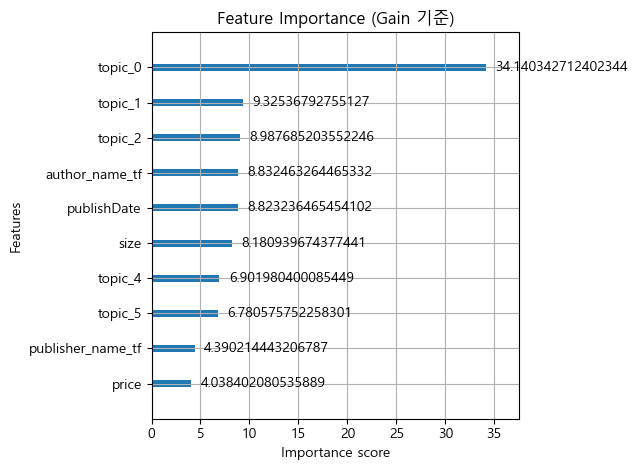

In [88]:
# 피처 중요도 시각화 (Gain 기준)
xgb.plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.title("Feature Importance (Gain 기준)")
plt.tight_layout()
plt.show()

c:\Users\hc\anaconda3\envs\py310\lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  pl.tight_layout()
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


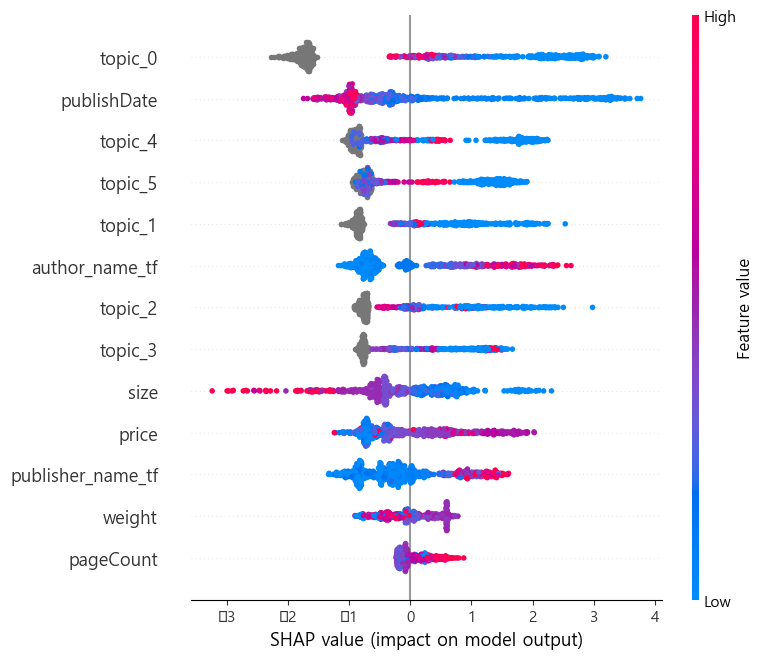

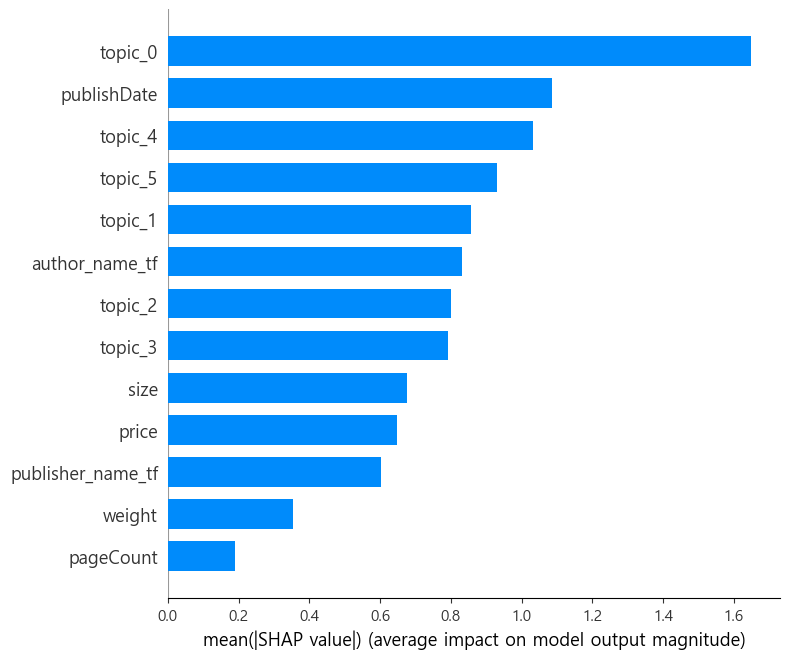

In [89]:
import shap

# SHAP 값 계산
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_val)

# 요약 시각화 (Summary plot)
shap.summary_plot(shap_values, X_val)
shap.summary_plot(shap_values, X_val, plot_type="bar")

In [90]:
print("Train Accuracy:", accuracy_score(y_train, best_model.predict(X_train)))
print("Val Accuracy:", accuracy_score(y_val, best_model.predict(X_val)))

Train Accuracy: 0.998707453683757
Val Accuracy: 0.951734539969834
